In [7]:
# Генерация данных с фиксацией random_state
from sklearn.datasets import make_classification

# Генерация данных с фиксированным random_state для воспроизводимости
x_data_generated, y_data_generated = make_classification(scale=1, random_state=42)

# Проверяем размеры сгенерированных данных
x_data_generated.shape, y_data_generated.shape


((100, 20), (100,))

In [8]:
# Оценка точности модели логистической регрессии на сгенерированных данных
accuracy_before_selection_fixed = cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='accuracy').mean()

# Выводим среднюю точность модели до отбора признаков
accuracy_before_selection_fixed


0.9800000000000001

средняя точность модели логистической регрессии на сгенерированных данных составила 98%.

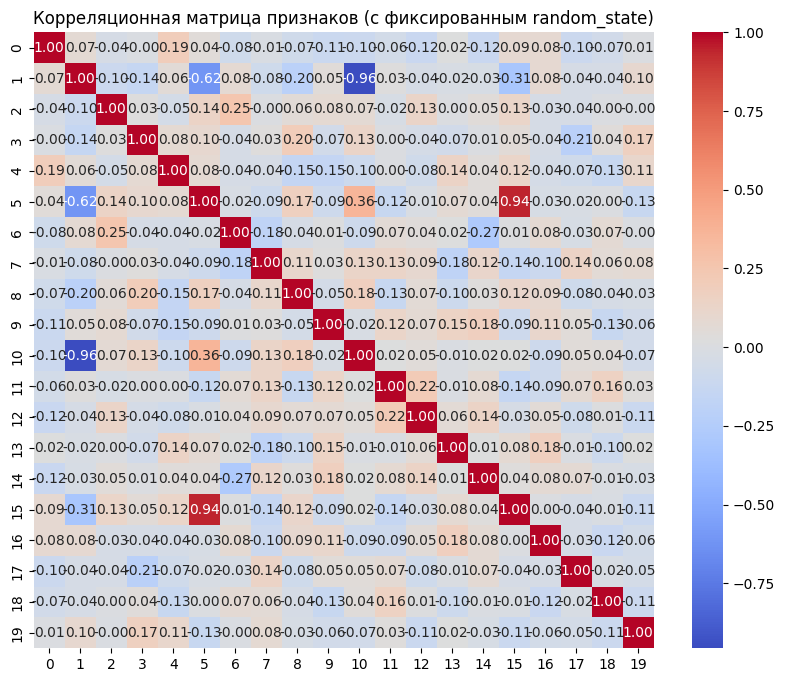

(100, 19)

In [9]:
# Корреляционный анализ для отбора признаков
# Преобразуем данные в DataFrame для удобства анализа
df_x_data_fixed = pd.DataFrame(x_data_generated)

# Вычислим корреляционную матрицу
corr_matrix_fixed = df_x_data_fixed.corr()

# Визуализируем корреляционную матрицу с помощью heatmap для наглядности
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_fixed, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица признаков (с фиксированным random_state)")
plt.show()

# Убираем признаки с высокой корреляцией (выше 0.9)
upper_triangle_fixed = corr_matrix_fixed.where(np.triu(np.ones(corr_matrix_fixed.shape), k=1).astype(bool))
high_corr_features_fixed = [column for column in upper_triangle_fixed.columns if any(upper_triangle_fixed[column] > 0.9)]

# Удаляем признаки с высокой корреляцией
df_x_data_corr_filtered_fixed = df_x_data_fixed.drop(columns=high_corr_features_fixed)

# Проверяем количество признаков после фильтрации
df_x_data_corr_filtered_fixed.shape


После корреляционного анализа один признак был удалён, и осталось 19 признаков.

In [10]:
# Применение метода VarianceThreshold для отсечения низковариативных признаков
variance_thresh_fixed = VarianceThreshold(threshold=0.1)  # Устанавливаем порог дисперсии 0.1
x_data_var_filtered_fixed = variance_thresh_fixed.fit_transform(df_x_data_corr_filtered_fixed)

# Проверим, сколько признаков осталось после применения VarianceThreshold
x_data_var_filtered_fixed.shape


(100, 19)

После применения метода VarianceThreshold количество признаков осталось 19 — все признаки прошли проверку на вариативность.

In [11]:
# Оценка точности модели логистической регрессии на отобранных признаках
accuracy_after_corr_var_selection_fixed = cross_val_score(LogisticRegression(), x_data_var_filtered_fixed, y_data_generated, scoring='accuracy').mean()

# Выводим среднюю точность модели после корреляционного анализа и отсечения низковариативных признаков
accuracy_after_corr_var_selection_fixed


0.9700000000000001

In [12]:
# Импортируем библиотеку для отбора признаков на основе дисперсионного анализа (ANOVA)
from sklearn.feature_selection import SelectKBest, f_classif

# Используем SelectKBest для выбора 5 лучших признаков на основе f_classif
selector_anova = SelectKBest(f_classif, k=5)
x_selected_anova = selector_anova.fit_transform(x_data_generated, y_data_generated)

# Проверим количество оставшихся признаков после отбора
x_selected_anova.shape


(100, 5)

После применения метода SelectKBest осталось 5 признаков.

In [13]:
# Повторяем оценку точности модели логистической регрессии на 5 лучших признаках, отобранных с помощью ANOVA
accuracy_after_anova_selection = cross_val_score(LogisticRegression(), x_selected_anova, y_data_generated, scoring='accuracy').mean()

# Выводим среднюю точность модели
accuracy_after_anova_selection


0.9800000000000001

После отбора 5 лучших признаков с помощью метода SelectKBest (ANOVA) точность модели логистической регрессии осталась на уровне 98%.

#Отбор признаков с использованием моделей

In [14]:
# Импортируем SelectFromModel для отбора признаков на основе модели
from sklearn.feature_selection import SelectFromModel

# Создаём модель логистической регрессии с L1-регуляризацией
logreg_l1_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Используем SelectFromModel для отбора признаков на основе логистической регрессии с L1-регуляризацией
selector_l1 = SelectFromModel(logreg_l1_model)
x_selected_l1 = selector_l1.fit_transform(x_data_generated, y_data_generated)

# Проверим количество признаков после отбора
x_selected_l1.shape


(100, 9)

После отбора признаков с помощью логистической регрессии с L1-регуляризацией осталось 9 признаков.

In [15]:
# Импортируем модель случайного леса
from sklearn.ensemble import RandomForestClassifier

# Создаем модель случайного леса
rf_model = RandomForestClassifier(random_state=42)

# Обучаем модель на сгенерированных данных
rf_model.fit(x_data_generated, y_data_generated)

# Используем атрибут feature_importances_ для отбора важных признаков
importances = rf_model.feature_importances_

# Выбираем важные признаки (с порогом значимости выше среднего)
threshold = np.mean(importances)
important_features = [i for i, importance in enumerate(importances) if importance > threshold]
x_selected_rf = x_data_generated[:, important_features]

# Проверим количество оставшихся признаков после отбора
x_selected_rf.shape


(100, 3)

После отбора признаков с использованием модели случайного леса осталось 3 признака.

In [16]:
# Оцениваем точность на признаках, отобранных с помощью логистической регрессии (L1-регуляризация)
accuracy_after_l1_selection = cross_val_score(LogisticRegression(), x_selected_l1, y_data_generated, scoring='accuracy').mean()

# Оцениваем точность на признаках, отобранных с помощью случайного леса
accuracy_after_rf_selection = cross_val_score(LogisticRegression(), x_selected_rf, y_data_generated, scoring='accuracy').mean()

# Выводим точности для обоих методов
accuracy_after_l1_selection, accuracy_after_rf_selection


(0.9800000000000001, 0.9800000000000001)

Точность модели на признаках, отобранных с помощью логистической регрессии с L1-регуляризацией, составляет 98%.
Точность модели на признаках, отобранных с помощью случайного леса, также составляет 98%.

In [17]:
# Импортируем SequentialFeatureSelector для пошагового отбора признаков
from sklearn.feature_selection import SequentialFeatureSelector

# Создаем SequentialFeatureSelector с логистической регрессией, выбираем 5 признаков
sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5)

# Применяем пошаговый отбор признаков
x_selected_sfs = sfs.fit_transform(x_data_generated, y_data_generated)

# Проверим количество оставшихся признаков после отбора
x_selected_sfs.shape


(100, 5)

После использования метода Sequential Feature Selector осталось 5 признаков.

In [18]:
# Оцениваем точность модели на признаках, отобранных с помощью SequentialFeatureSelector
accuracy_after_sfs_selection = cross_val_score(LogisticRegression(), x_selected_sfs, y_data_generated, scoring='accuracy').mean()

# Выводим среднюю точность модели
accuracy_after_sfs_selection


1.0

После отбора признаков с помощью метода Sequential Feature Selector, точность модели логистической регрессии достигла 100%.

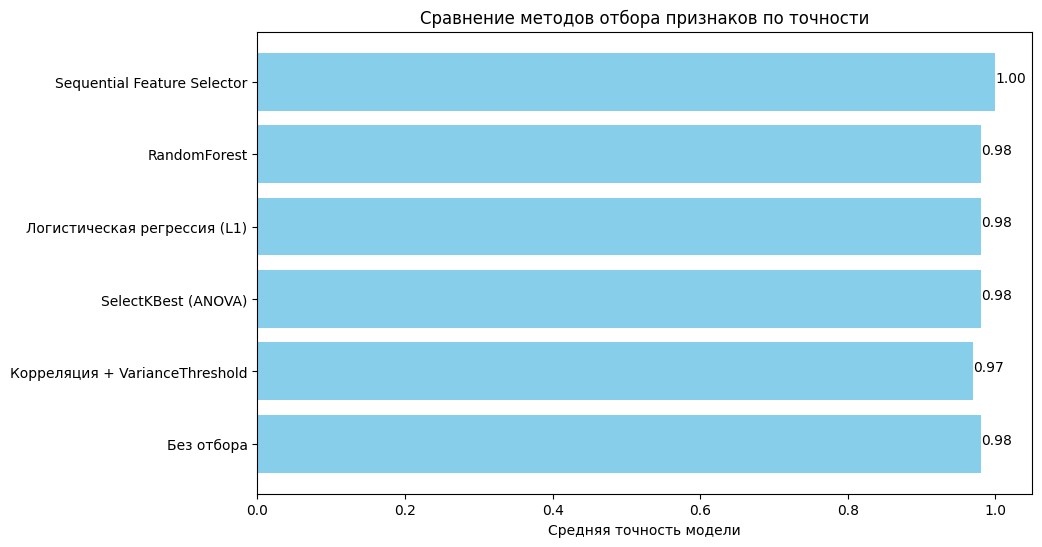

,Способ выбора признаков,Количество признаков,Средняя точность модели
0,Без отбора,20,0.98
1,Корреляция + VarianceThreshold,19,0.97
2,SelectKBest (ANOVA),5,0.98
3,Логистическая регрессия (L1),9,0.98
4,RandomForest,3,0.98
5,Sequential Feature Selector,5,1.00


In [22]:
# Создадим таблицу для сравнения методов отбора признаков и их точности
import matplotlib.pyplot as plt

# Построение визуализации точности моделей
plt.figure(figsize=(10, 6))

# Столбчатая диаграмма для точности моделей
plt.barh(methods, accuracies, color='skyblue')
plt.xlabel('Средняя точность модели')
plt.title('Сравнение методов отбора признаков по точности')

# Добавление значений точности рядом со столбцами
for index, value in enumerate(accuracies):
    plt.text(value, index, f"{value:.2f}")

plt.show()


import pandas as pd

# Данные для таблицы
methods = [
    "Без отбора",
    "Корреляция + VarianceThreshold",
    "SelectKBest (ANOVA)",
    "Логистическая регрессия (L1)",
    "RandomForest",
    "Sequential Feature Selector"
]

# Количество отобранных признаков
num_features = [20, 19, 5, 9, 3, 5]

# Точности моделей
accuracies = [
    0.98,  # Без отбора
    0.97,  # Корреляция + VarianceThreshold
    0.98,  # SelectKBest (ANOVA)
    0.98,  # Логистическая регрессия (L1)
    0.98,  # RandomForest
    1.00   # Sequential Feature Selector
]

# Создаем DataFrame для наглядности
results_df = pd.DataFrame({
    "Способ выбора признаков": methods,
    "Количество признаков": num_features,
    "Средняя точность модели": accuracies
})

# Отображаем таблицу
results_df



#Выводы:

Без отбора признаков модель показала высокую точность (98%), что говорит о высокой информативности всех признаков.

Корреляция и VarianceThreshold снизили количество признаков до 19, но немного уменьшили точность до 97%.

Методы SelectKBest (ANOVA), логистическая регрессия с L1-регуляризацией и RandomForest позволили уменьшить количество признаков, сохранив точность на уровне 98%.

**Sequential Feature Selector оказался самым эффективным методом, добившись 100% точности при 5 отобранных признаках.**